# NYC Hospitals Analysis

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NYC-Hospitals-Analysis" data-toc-modified-id="NYC-Hospitals-Analysis-1">NYC Hospitals Analysis</a></span><ul class="toc-item"><li><span><a href="#Select-NYC-Data" data-toc-modified-id="Select-NYC-Data-1.1">Select NYC Data</a></span><ul class="toc-item"><li><span><a href="#Labor-Force-Trends-In-New-York-State" data-toc-modified-id="Labor-Force-Trends-In-New-York-State-1.1.1">Labor Force Trends In New York State</a></span></li><li><span><a href="#Generate-Hospitals-Buffer-(500-Feet)" data-toc-modified-id="Generate-Hospitals-Buffer-(500-Feet)-1.1.2">Generate Hospitals Buffer (500 Feet)</a></span></li></ul></li><li><span><a href="#Create-Unique-Workers-Home-Census-Blocks-List" data-toc-modified-id="Create-Unique-Workers-Home-Census-Blocks-List-1.2">Create Unique Workers Home Census Blocks List</a></span></li><li><span><a href="#What-states-do-Workers-near-Hospitals-live-in?" data-toc-modified-id="What-states-do-Workers-near-Hospitals-live-in?-1.3">What states do Workers near Hospitals live in?</a></span></li><li><span><a href="#Select-Worker's-Near-Hospitals-Home-Census-Blocks" data-toc-modified-id="Select-Worker's-Near-Hospitals-Home-Census-Blocks-1.4">Select Worker's Near Hospitals Home Census Blocks</a></span></li><li><span><a href="#Select-Features-for-Map" data-toc-modified-id="Select-Features-for-Map-1.5">Select Features for Map</a></span></li></ul></li></ul></div>

In [241]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
from project.source_data.hospitals import get_hospitals
from project.source_data.lodes import get_lodes
from project.source_data.census import get_census
from project.tools.tools import create_directory

In [243]:
import pandas as pd
import geopandas as gpd

In [244]:
hospitals = get_hospitals()

In [245]:
lodes, block_crosswalk = get_lodes()
lodes_file_list = lodes['2016']

In [246]:
# crosswalk = pd.read_csv(block_crosswalk, dtype={
#     'tabblk2010': object,
#     'st': object,
#     'cty': object,
#     'trct': object,
#     'trct': object,
#     'bgrp': object,
# })
# crosswalk.head(3)

In [247]:
# crosswalk['st'].value_counts()

## Select NYC Data

In [248]:
hospitals = hospitals[ 
    (
        (hospitals['COUNTYFIPS'] == '36081') |
        (hospitals['COUNTYFIPS'] == '36061') |
        (hospitals['COUNTYFIPS'] == '36085') |
        (hospitals['COUNTYFIPS'] == '36047') |
        (hospitals['COUNTYFIPS'] == '36005') 
    )  # select only nyc counties
]

In [249]:
ny_blocks = gpd.read_file(
    '../data/input/census/tl_2017_36_tabblock10/tl_2017_36_tabblock10.shp',
    dtype={'GEOID10': object},
)

In [250]:
ny_blocks["longitude"] = ny_blocks.centroid.x
ny_blocks["latitude"] = ny_blocks.centroid.y

In [251]:
ny_blocks = ny_blocks[['GEOID10', 'geometry', 'longitude', 'latitude']]

ny_blocks.head()

,GEOID10,geometry,longitude,latitude
0,360271200001028,"POLYGON ((-73.72369 41.98861, -73.72354 41.988...",-73.714221,41.988534
1,360150112005049,"POLYGON ((-76.73183 42.01556, -76.73181 42.015...",-76.731293,42.013349
2,361031464022010,"POLYGON ((-73.14913 40.74997, -73.14860 40.750...",-73.147874,40.753130
3,360594151021015,"POLYGON ((-73.54886 40.65129, -73.54849 40.650...",-73.545607,40.647786
4,360499501002196,"POLYGON ((-75.36801 43.93287, -75.36794 43.933...",-75.367040,43.933115


In [252]:
ny_lodes_files = [s for s in lodes_file_list if 'ny' in s]  # search for 'ny' substring in lodes file list

In [253]:
df_list = []

for f in ny_lodes_files:
    df = pd.read_csv(f, dtype={
        'h_geocode': object,
        'w_geocode': object,
    })
    print(df.shape[0])
    df_list.append(df)
    
df = pd.concat(df_list, sort=True)
print(df.shape[0])

7553540
702717
8256257


### Labor Force Trends In New York State

> In 2016, the number of employed workers across New York State averaged more than 9.1
million Source: Labor Force Trends
In New York State: https://www.osc.state.ny.us/reports/economic/labor-force-trends-nys-2017.pdf

In [254]:
ny_lodes = df[
    (df['w_geocode'].astype(str).str.startswith('36081')) |
    (df['w_geocode'].astype(str).str.startswith('36061')) |
    (df['w_geocode'].astype(str).str.startswith('36085')) |
    (df['w_geocode'].astype(str).str.startswith('36047')) |
    (df['w_geocode'].astype(str).str.startswith('36005')) 
]  # select only nyc work geocodes
 
ny_lodes = ny_lodes[['S000', 'w_geocode', 'h_geocode']]   # Total number of jobs, Workplace Census Block Code, Residence Census Block Code   

ny_lodes['h_state_fips'] = ny_lodes['h_geocode'].astype(str).str[:2]

print(ny_lodes.shape[0])

ny_lodes.head()

3835918


,S000,w_geocode,h_geocode,h_state_fips
217352,1,360050001001002,360010146151001,36
217353,1,360050001001002,360050002001001,36
217354,1,360050001001002,360050002001003,36
217355,1,360050001001002,360050004002005,36
217356,1,360050001001002,360050004004000,36


### Generate Hospitals Buffer (500 Feet)

In [255]:
hospitals_buffer = hospitals.to_crs(epsg=2263) 
hospitals_buffer['geometry'] = hospitals_buffer['geometry'].buffer(500) 

In [256]:
hospitals_buffer_int_blocks = gpd.sjoin(
    hospitals_buffer, 
    ny_blocks.to_crs(epsg=2263),
    how="left",
    op='intersects',  
)

In [257]:
hospital_blocks = hospitals_buffer_int_blocks.copy()
hospital_blocks.head(3)

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry,index_right,GEOID10,longitude,latitude
399,400,0015210036,JACOBI MEDICAL CENTER,1400 PELHAM PARKWAY SOUTH,BRONX,NY,10036,NOT AVAILABLE,(212) 430-5235,GENERAL ACUTE CARE,...,GOVERNMENT - LOCAL,-999,457,LEVEL I,Y,"POLYGON ((1026932.808 251286.836, 1026930.401 ...",264568,360050296001008,-73.846649,40.857747
399,400,0015210036,JACOBI MEDICAL CENTER,1400 PELHAM PARKWAY SOUTH,BRONX,NY,10036,NOT AVAILABLE,(212) 430-5235,GENERAL ACUTE CARE,...,GOVERNMENT - LOCAL,-999,457,LEVEL I,Y,"POLYGON ((1026932.808 251286.836, 1026930.401 ...",269479,360050296002000,-73.846229,40.854512
400,401,0015310466,MONTEFIORE MEDICAL CENTER - MOSES DIVISION,111 E 210TH ST,BRONX,NY,10466,NOT AVAILABLE,(718) 920-4321,GENERAL ACUTE CARE,...,NON-PROFIT,-999,779,NOT AVAILABLE,N,"POLYGON ((1017981.734 259937.228, 1017979.326 ...",312660,360050419001000,-73.878714,40.878782


In [258]:
unique_hospital_blocks = list(hospital_blocks['GEOID10'].unique())
len(unique_hospital_blocks)

649

In [259]:
ny_lodes_hospital_blocks = ny_lodes[ny_lodes['w_geocode'].isin(unique_hospital_blocks)]

ny_lodes_hospital_blocks.shape[0]

287922

## Create Unique Workers Home Census Blocks List

In [260]:
home_blocks_of_hospital_workers_list = list(ny_lodes_hospital_blocks['h_geocode'].unique())

In [261]:
len(home_blocks_of_hospital_workers_list)

80617

## What states do Workers near Hospitals live in? 

In [262]:
unique_states_workers = ny_lodes_hospital_blocks['h_state_fips'].value_counts().rename_axis('state_fips').reset_index(name='counts')


In [263]:
unique_states_workers.head(10)

,state_fips,counts
0,36,254570
1,34,26404
2,09,2769
3,42,2221
4,25,613
5,24,309
6,51,114
7,12,103
8,06,100
9,44,97


In [264]:
unique_states_workers_greater_500_workers = unique_states_workers[unique_states_workers['counts'] >= 500]
states_fips_with_at_least_500_workers = list(unique_states_workers_greater_500_workers['state_fips'].unique())
states_fips_with_at_least_500_workers 

['36', '34', '09', '42', '25']

## Select Worker's Near Hospitals Home Census Blocks 

In [265]:
gdf_list = []

for state_fips in states_fips_with_at_least_500_workers:
    print('for state:', state_fips)
    
    gdf = gpd.read_file(
        f'../data/input/census/tl_2017_{state_fips}_tabblock10/tl_2017_{state_fips}_tabblock10.shp',
        dtype={'GEOID10': object},
    )
    
    print('has:', gdf.shape[0], 'census blocks')
    
    gdf = gdf[gdf['GEOID10'].isin(home_blocks_of_hospital_workers_list)]
    
    print('has:', gdf.shape[0]), 'census blocks with workers near nyc hospitals'
    
    gdf_list.append(gdf)

gdf = pd.concat(gdf_list, sort=True)

print(gdf.shape[0])

for state: 36
has: 350169 census blocks
has: 57453
for state: 34
has: 169588 census blocks
has: 16793
for state: 09
has: 67578 census blocks
has: 2349
for state: 42
has: 421545 census blocks
has: 2074
for state: 25
has: 157508 census blocks
has: 610
79279


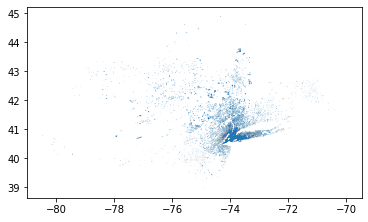

In [266]:
gdf.plot()

In [267]:
gdf["h_longitude"] = gdf.centroid.x
gdf["h_latitude"] = gdf.centroid.y

In [268]:
gdf[['GEOID10', 'h_longitude', 'h_latitude']].head(3) 

,GEOID10,h_longitude,h_latitude
5,360499501002111,-75.225720,43.976950
24,361090009001017,-76.540553,42.463034
30,361090011003015,-76.493709,42.411084


In [269]:
ny_blocks[['GEOID10', 'longitude', 'latitude']].head(3)

,GEOID10,longitude,latitude
0,360271200001028,-73.714221,41.988534
1,360150112005049,-76.731293,42.013349
2,361031464022010,-73.147874,40.753130


## Select Features for Map

In [270]:
from shapely.geometry import LineString, Point

In [271]:
for hospital_id in list(hospitals['ID'].unique()):
    print(hospital_id)
    
    create_directory(f'../data/processing/{hospital_id}')
    
    hospital = hospitals[hospitals['ID'] == hospital_id] 
    hospital.to_file(
        f'../data/processing/{hospital_id}/hospital.gpkg',
        driver="GPKG",
    )
    
    sel_hospital_blocks = list(hospital_blocks[hospital_blocks['ID'] == hospital_id]['GEOID10'].unique())
    sel_hospital_blocks_geo = ny_blocks[ny_blocks['GEOID10'].isin(sel_hospital_blocks)]                                                                                                                                                                 
    sel_hospital_blocks_geo.to_file(
        f'../data/processing/{hospital_id}/hospital_blocks.gpkg',
        driver="GPKG",
    )
    
    home_and_work = ny_lodes[ny_lodes['w_geocode'].isin(sel_hospital_blocks)]
    
    home_and_work = home_and_work.merge(
        gdf[['GEOID10', 'h_longitude', 'h_latitude']],
        left_on='h_geocode', 
        right_on='GEOID10',
        how='left',
    )
    home_and_work.drop(columns='GEOID10', inplace=True)
    
    home_and_work = home_and_work.merge(
        ny_blocks[['GEOID10', 'longitude', 'latitude']],
        left_on='w_geocode', 
        right_on='GEOID10',
        how='left',
    )
    home_and_work.drop(columns='GEOID10', inplace=True)

    home_and_work['geom_work'] = gpd.points_from_xy(home_and_work['longitude'], home_and_work['latitude'])
    home_and_work['geom_home'] = gpd.points_from_xy(home_and_work['h_longitude'], home_and_work['h_latitude'])
    home_and_work['geometry'] = home_and_work.apply(
        lambda x: LineString([
            x['geom_work'], 
            x['geom_home'],
        ]), 
        axis=1,
    )
    
    home_and_work.to_csv(
        f'../data/processing/{hospital_id}/home_and_work.csv',
        index=False,
    )
    
    home_and_work_lines = gpd.GeoDataFrame(
        home_and_work.drop(columns=['geom_work', 'geom_home']), 
        geometry='geometry',
    )
    
    home_and_work_lines.to_file(
        f'../data/processing/{hospital_id}/home_and_work_lines.gpkg',
        driver="GPKG",
    )
    

0015210036
0015310466
0015610467
0016111212
0016211201
0016310461
0016411203
0016611235
0016711201
0016911209
0017011215
0017910003
0018610032
0018810019
0019611373
0019711414
0020311355
0020610301
0020710305
0114010016
0115411234
0116710037
0116810035
0116910457
0118510466
0118710025
0118810032
0118910021
0119511201
0010610468
0021210305
0117510021
0015010456
0017311237
0018110021
0019210304
0019411355
0019811691
0114210457
0115610034
0116610021
0118610019
0119310038
0016511229
0018910021
0015510461
0016811219
0018010021
0018210029
0018410003
0018710001
0019511432
0020011375
0020211206
0114611203
0114710011
0114811040
0115511102
0118110461
0119111203
0119410016
0120210304
0121210003
0010710010
0011011209
0011211425
0019310044
0013710461
0017111213
0169510461
0169610461
0170311203
0170510035
0170610035
0171110032
0171811427
0177611426
0175910305
0019010044
0015710451


In [272]:
hospitals

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
399,400,0015210036,JACOBI MEDICAL CENTER,1400 PELHAM PARKWAY SOUTH,BRONX,NY,10036,NOT AVAILABLE,(212) 430-5235,GENERAL ACUTE CARE,...,http://www.nyc.gov/html/hhc/jacobi/home.html,7000002H,NOT AVAILABLE,36,GOVERNMENT - LOCAL,-999,457,LEVEL I,Y,POINT (-73.84751 40.85630)
400,401,0015310466,MONTEFIORE MEDICAL CENTER - MOSES DIVISION,111 E 210TH ST,BRONX,NY,10466,NOT AVAILABLE,(718) 920-4321,GENERAL ACUTE CARE,...,http://www.montefiore.org,7000006H,NOT AVAILABLE,36,NON-PROFIT,-999,779,NOT AVAILABLE,N,POINT (-73.87983 40.88008)
402,403,0015610467,NORTH CENTRAL BRONX HOSPITAL,3424 KOSSUTH AVE,BRONX,NY,10467,NOT AVAILABLE,(718) 519-5000,GENERAL ACUTE CARE,...,http://www.nyc.gov/html/hhc/ncbh/html/home/hom...,7000024H,NOT AVAILABLE,36,GOVERNMENT - LOCAL,-999,213,NOT AVAILABLE,N,POINT (-73.88106 40.88037)
404,405,0016111212,BROOKDALE HOSPITAL MEDICAL CENTER,1 BROOKDALE PLAZA,BROOKLYN,NY,11212,NOT AVAILABLE,(718) 240-5000,GENERAL ACUTE CARE,...,http://www.brookdalehospital.org,7001002H,NOT AVAILABLE,36,NON-PROFIT,-999,530,LEVEL II,N,POINT (-73.91256 40.65527)
405,406,0016211201,BROOKLYN HOSPITAL CENTER,121 DEKALB AVE,BROOKLYN,NY,11201,NOT AVAILABLE,(718) 250-8000,GENERAL ACUTE CARE,...,http://www.tbh.org,7001003H,NOT AVAILABLE,36,NON-PROFIT,-999,464,NOT AVAILABLE,N,POINT (-73.97788 40.69057)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500,3920,0171811427,CREEDMOOR PSYCHIATRIC CENTER,79-25 WINCHESTER BLVD,QUEENS VILLAGE,NY,11427,2147,(718) 464-7500,PSYCHIATRIC,...,https://www.omh.ny.gov/omhweb/facilities/crpc/,NOT AVAILABLE,NOT AVAILABLE,36,GOVERNMENT - STATE,-999,-999,NOT AVAILABLE,N,POINT (-73.73153 40.74114)
5501,3921,0177611426,NEW YORK CITY CHILDREN'S CENTER QUEENS INPATIENT,74-03 COMMONWEALTH BLVD,BELLEROSE,NY,11426,NOT AVAILABLE,(718) 264-4500,PSYCHIATRIC,...,https://www.omh.ny.gov/omhweb/facilities/nyccc...,NOT AVAILABLE,NOT AVAILABLE,36,GOVERNMENT - STATE,-999,-999,NOT AVAILABLE,N,POINT (-73.72574 40.74554)
5502,3922,0175910305,SOUTH BEACH PSYCHIATRIC CENTER,777 SEAVIEW AVENUE,STATEN ISLAND,NY,10305,NOT AVAILABLE,(718) 667-2300,PSYCHIATRIC,...,https://www.omh.ny.gov/omhweb/facilities/sbpc/,NOT AVAILABLE,NOT AVAILABLE,36,GOVERNMENT - STATE,-999,-999,NOT AVAILABLE,N,POINT (-74.08062 40.58202)
5836,6256,0019010044,COLER-GOLDWATER SPECIALTY HOSPITAL & NURSING F...,900 MAIN STREET ROOSEVELT ISLAND,NEW YORK,NY,10044,NOT AVAILABLE,(212) 848-6000,LONG TERM CARE,...,http://www.nychealthandhospitals.org/coler/,7002051H,NOT AVAILABLE,36,GOVERNMENT - LOCAL,-999,210,NOT AVAILABLE,N,POINT (-73.94214 40.77030)


In [273]:
hospital_blocks[['ID', 'GEOID10']]

,ID,GEOID10
399,0015210036,360050296001008
399,0015210036,360050296002000
400,0015310466,360050419001000
400,0015310466,360050419001001
400,0015310466,360050419001002
...,...,...
6390,0015710451,360050051001000
6390,0015710451,360050065004003
6390,0015710451,360050065002004
6390,0015710451,360050061003002


In [274]:
hospitals.head(80)

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
399,400,0015210036,JACOBI MEDICAL CENTER,1400 PELHAM PARKWAY SOUTH,BRONX,NY,10036,NOT AVAILABLE,(212) 430-5235,GENERAL ACUTE CARE,...,http://www.nyc.gov/html/hhc/jacobi/home.html,7000002H,NOT AVAILABLE,36,GOVERNMENT - LOCAL,-999,457,LEVEL I,Y,POINT (-73.84751 40.85630)
400,401,0015310466,MONTEFIORE MEDICAL CENTER - MOSES DIVISION,111 E 210TH ST,BRONX,NY,10466,NOT AVAILABLE,(718) 920-4321,GENERAL ACUTE CARE,...,http://www.montefiore.org,7000006H,NOT AVAILABLE,36,NON-PROFIT,-999,779,NOT AVAILABLE,N,POINT (-73.87983 40.88008)
402,403,0015610467,NORTH CENTRAL BRONX HOSPITAL,3424 KOSSUTH AVE,BRONX,NY,10467,NOT AVAILABLE,(718) 519-5000,GENERAL ACUTE CARE,...,http://www.nyc.gov/html/hhc/ncbh/html/home/hom...,7000024H,NOT AVAILABLE,36,GOVERNMENT - LOCAL,-999,213,NOT AVAILABLE,N,POINT (-73.88106 40.88037)
404,405,0016111212,BROOKDALE HOSPITAL MEDICAL CENTER,1 BROOKDALE PLAZA,BROOKLYN,NY,11212,NOT AVAILABLE,(718) 240-5000,GENERAL ACUTE CARE,...,http://www.brookdalehospital.org,7001002H,NOT AVAILABLE,36,NON-PROFIT,-999,530,LEVEL II,N,POINT (-73.91256 40.65527)
405,406,0016211201,BROOKLYN HOSPITAL CENTER,121 DEKALB AVE,BROOKLYN,NY,11201,NOT AVAILABLE,(718) 250-8000,GENERAL ACUTE CARE,...,http://www.tbh.org,7001003H,NOT AVAILABLE,36,NON-PROFIT,-999,464,NOT AVAILABLE,N,POINT (-73.97788 40.69057)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500,3920,0171811427,CREEDMOOR PSYCHIATRIC CENTER,79-25 WINCHESTER BLVD,QUEENS VILLAGE,NY,11427,2147,(718) 464-7500,PSYCHIATRIC,...,https://www.omh.ny.gov/omhweb/facilities/crpc/,NOT AVAILABLE,NOT AVAILABLE,36,GOVERNMENT - STATE,-999,-999,NOT AVAILABLE,N,POINT (-73.73153 40.74114)
5501,3921,0177611426,NEW YORK CITY CHILDREN'S CENTER QUEENS INPATIENT,74-03 COMMONWEALTH BLVD,BELLEROSE,NY,11426,NOT AVAILABLE,(718) 264-4500,PSYCHIATRIC,...,https://www.omh.ny.gov/omhweb/facilities/nyccc...,NOT AVAILABLE,NOT AVAILABLE,36,GOVERNMENT - STATE,-999,-999,NOT AVAILABLE,N,POINT (-73.72574 40.74554)
5502,3922,0175910305,SOUTH BEACH PSYCHIATRIC CENTER,777 SEAVIEW AVENUE,STATEN ISLAND,NY,10305,NOT AVAILABLE,(718) 667-2300,PSYCHIATRIC,...,https://www.omh.ny.gov/omhweb/facilities/sbpc/,NOT AVAILABLE,NOT AVAILABLE,36,GOVERNMENT - STATE,-999,-999,NOT AVAILABLE,N,POINT (-74.08062 40.58202)
5836,6256,0019010044,COLER-GOLDWATER SPECIALTY HOSPITAL & NURSING F...,900 MAIN STREET ROOSEVELT ISLAND,NEW YORK,NY,10044,NOT AVAILABLE,(212) 848-6000,LONG TERM CARE,...,http://www.nychealthandhospitals.org/coler/,7002051H,NOT AVAILABLE,36,GOVERNMENT - LOCAL,-999,210,NOT AVAILABLE,N,POINT (-73.94214 40.77030)


In [275]:
hospitals.to_csv('hosps.csv', index=False)